# Capstone Project 
# Housing Sales Rate & Neighborhoods Analysis of Chennai, India

-------

## Week 1 Activity

### A. Introduction
Chennai is one of the four major metrocities of India. Area of the city is **426 square km**. Population of the city is close to **8.6 Million**. The city is divided in mainly Four Zones i.e

1. Chennai North
2. Chennai South
3. Chennai West
4. Chennai East

These zones are further divided in several neighbourhoods. All these neighbourhoods have different housing rates and different amenities for public utilisation.\
For anyone new to the city it gets challenging to find a neighbourhood of choice given the variation in housing rates and the available amenities.

### B. Problem Description
Chennai being a major city with huge area and several differences in neighbourhoods, **buyers or investors** find it difficult to zero-in on the housing they have to buy.\
As a solution we will create a map that would cluster the similar neighbourhoods based on the housing rate and available amenities.

### C. Data Description
To create a map with clustered neighbourhoods I will utilise the available data in the below websites.

1. The link here will be used to get the information of housing rates of various housing socities rate. [Data for Housing Socities Rate][1]. This will contain data of several housing societies and the range of prices for same.
2. The link here will be used to get the geo cordinates for various neighbourhoods. [Data for Neighbourhood coordinates][2]. This data will have the geo coordinates of neighbourhoods.
4. I will use the **Foursquare API** to get the neighbourhood venues for these neighbourhoods.
There are going to be some challenges about the how the extensive data is available.\
For example, the [link here][2] does not have geo coordinates for all the neighbourhoods and **Foursquare.com** does not have very extensive list of venues of these neighbourhoods.

[1]:https://www.99acres.com/property-rates-and-price-trends-in-chennai
[2]:https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Chennai

### D. Approach
The below mentioned is the approach that I will utilise to get the desired result

1. I will utilise **BeautifulSoup** library to extract relevant information for housing societies rate from [here][1].
2. Then I will use **Pandas** library to process the data to create a dataframe that has neighbourhood name with average housing rates.
3. The [Wikipedia Page][2] will be utilised to get the geo coordinates for the neighbourhoods. The neighbourhoods for which geo coordinates will not be available, migh have to be removed from dataframe.
4. The **Foursquare API** will be utilised to get the top venues for these neighbourhoods.
5. **K-Means** library and algorithm will be utilised to cluster these neighbourhoods based on top venues and average rate of housing.
6. **Folium** library will be utilised to create a map of Chennai with marker of clustered neighbourhoods.

This is the initial methodology defined on how the data will be processed to arrive at conclusion. Depending on the data quality there can be minor changes on the methodology deployed.

[1]:https://www.99acres.com/property-rates-and-price-trends-in-chennai
[2]:https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Chennai

---------------------
## Week 2 Activity

### E. Methodology
In this section I will proceed step-by-step from web scraping to final result.\
In various subsection below I will explain the steps and outcomes.

#### 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd

import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

!pip install bs4
from bs4 import BeautifulSoup

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print("Libraries Imported")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    openssl-1.1.1k             |       h7f98852_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.3 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be UPDATED:

  certifi                          2020.12.5-py

#### 2. Web scraping

In [2]:
## Create URL
url = 'https://www.99acres.com/property-rates-and-price-trends-in-societies-in-chennai'
url

'https://www.99acres.com/property-rates-and-price-trends-in-societies-in-chennai'

In [3]:
#Get URL result
result = requests.get(url).text

In [4]:
#Create BeautiFul Soup object and pass "results" 
soup = BeautifulSoup(result, "html.parser")

In [5]:
#Get table from soup
table = soup.find_all('tbody')[0]

In [6]:
#Table rows
table_rows = table.find_all('tr')

In [7]:
#For loop to get table rows data in a data frame
table_rows_list = []
for data in table_rows:
    table_rows_list.append(data.text)

table_data= pd.DataFrame(table_rows_list)
table_data.columns = ['Row1']
table_data.head()

,Row1
0,Chennai West
1,"\nAkshaya Republic, Kovur\nRs. 4,972 - 5,398/s..."
2,"\nAltis Ashraya, Mangadu\nRs. 4,378 - 4,462/sq..."
3,"\nArihant Tiara, Nandambakkam\nRs. 6,375 - 6,3..."
4,"\nBharathi Brikhouse, Vanagaram\nRs. 5,185 - 5..."


In [8]:
table_data.shape

(173, 1)

In [9]:
#apply split to get the data in seperate columns
table_aranged = table_data.Row1.str.split('\n',expand=True)
table_aranged.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,Chennai West,None,None,None,None,None,None,None,None,None,None,None
1,,"Akshaya Republic, Kovur","Rs. 4,972 - 5,398/sq. ft.",6.9%,,,See Trends,,,Not Available,,
2,,"Altis Ashraya, Mangadu","Rs. 4,378 - 4,462/sq. ft.",5%,,,See Trends,,,Not Available,,
3,,"Arihant Tiara, Nandambakkam","Rs. 6,375 - 6,375/sq. ft.",-,,Not Available,,,Not Available,,,None
4,,"Bharathi Brikhouse, Vanagaram","Rs. 5,185 - 5,610/sq. ft.",6.5%,,,See Trends,,,Not Available,,


In [10]:
table_aranged.shape

(173, 12)

#### 3. Data cleaning
For our project we only need values in column 1 and 2. So we will create another dataframe with these two column only.

In [11]:
society_data = table_aranged[[1,2]]
society_data.columns = ['Society name','Range']
society_data.head()

,Society name,Range
0,None,None
1,"Akshaya Republic, Kovur","Rs. 4,972 - 5,398/sq. ft."
2,"Altis Ashraya, Mangadu","Rs. 4,378 - 4,462/sq. ft."
3,"Arihant Tiara, Nandambakkam","Rs. 6,375 - 6,375/sq. ft."
4,"Bharathi Brikhouse, Vanagaram","Rs. 5,185 - 5,610/sq. ft."


Several of the rows in the table has values as 'None'. Those rows will be deleted.\
The columns Society name contains neighbourhood name as well. The neighbourhood name will be extracted to a seperate column.\
The range column shows minimum and maximum rate of these societies. It also contains strings and numbers in strings form. This columns will be cleaned too.

In [12]:
print('Number rows in the table is {}'.format(society_data.shape[0]))

Number rows in the table is 173


In [13]:
society_data.describe(include='all')

,Society name,Range
count,169,169
unique,169,167
top,"Urbanrise Jubilee Residences, Guduvancheri","Rs. 4,122 - 4,122/sq. ft."
freq,1,2


In [14]:
society_data.isnull().sum()

Society name    4
Range           4
dtype: int64

In [15]:
# replace all 'None' values with NaN
society_data1 = society_data.replace('None',np.NaN)
society_data1.head()

,Society name,Range
0,None,None
1,"Akshaya Republic, Kovur","Rs. 4,972 - 5,398/sq. ft."
2,"Altis Ashraya, Mangadu","Rs. 4,378 - 4,462/sq. ft."
3,"Arihant Tiara, Nandambakkam","Rs. 6,375 - 6,375/sq. ft."
4,"Bharathi Brikhouse, Vanagaram","Rs. 5,185 - 5,610/sq. ft."


In [16]:
society_data[society_data['Society name']== None].value_counts()

Series([], dtype: int64)

In [17]:
# drop all NaN values
society_data1.dropna(subset=['Society name','Range'],axis=0,inplace=True)
society_data1.head()

,Society name,Range
1,"Akshaya Republic, Kovur","Rs. 4,972 - 5,398/sq. ft."
2,"Altis Ashraya, Mangadu","Rs. 4,378 - 4,462/sq. ft."
3,"Arihant Tiara, Nandambakkam","Rs. 6,375 - 6,375/sq. ft."
4,"Bharathi Brikhouse, Vanagaram","Rs. 5,185 - 5,610/sq. ft."
5,"Dugar Sky City, Vanagaram","Rs. 5,185 - 6,078/sq. ft."


In [18]:
#Now check the number of rows left, it should be 169
society_data1.shape

(169, 2)

In [19]:
society_data1.isnull().sum()

Society name    0
Range           0
dtype: int64

In [20]:
#resetting index
society_data1.reset_index(drop=True,inplace=True)
society_data1.head()

,Society name,Range
0,"Akshaya Republic, Kovur","Rs. 4,972 - 5,398/sq. ft."
1,"Altis Ashraya, Mangadu","Rs. 4,378 - 4,462/sq. ft."
2,"Arihant Tiara, Nandambakkam","Rs. 6,375 - 6,375/sq. ft."
3,"Bharathi Brikhouse, Vanagaram","Rs. 5,185 - 5,610/sq. ft."
4,"Dugar Sky City, Vanagaram","Rs. 5,185 - 6,078/sq. ft."


In [21]:
#Split "Society name" column
society_data1.rename(columns={'Society name':'Society'},inplace=True)

society_data1[['Society','Neighbourhood']] = society_data1.Society.str.split(', ', expand=True)
society_data1.head()

,Society,Range,Neighbourhood
0,Akshaya Republic,"Rs. 4,972 - 5,398/sq. ft.",Kovur
1,Altis Ashraya,"Rs. 4,378 - 4,462/sq. ft.",Mangadu
2,Arihant Tiara,"Rs. 6,375 - 6,375/sq. ft.",Nandambakkam
3,Bharathi Brikhouse,"Rs. 5,185 - 5,610/sq. ft.",Vanagaram
4,Dugar Sky City,"Rs. 5,185 - 6,078/sq. ft.",Vanagaram


In [22]:
society_data1.isnull().sum()

Society          0
Range            0
Neighbourhood    0
dtype: int64

In [23]:
#Now let's split 'Range' column
society_data1[['Range','Max']] = society_data1.Range.str.split(' - ', expand=True)
society_data1.head()

,Society,Range,Neighbourhood,Max
0,Akshaya Republic,"Rs. 4,972",Kovur,"5,398/sq. ft."
1,Altis Ashraya,"Rs. 4,378",Mangadu,"4,462/sq. ft."
2,Arihant Tiara,"Rs. 6,375",Nandambakkam,"6,375/sq. ft."
3,Bharathi Brikhouse,"Rs. 5,185",Vanagaram,"5,610/sq. ft."
4,Dugar Sky City,"Rs. 5,185",Vanagaram,"6,078/sq. ft."


In [24]:
#Further split the 'Range' column, and get the numerical values and convert to 'integer' data-type
society_data1[['Range','Min']]=society_data1.Range.str.split(' ',expand=True)
society_data1['Min'] = society_data1['Min'].apply(lambda x: x.replace(',','')).astype('int')
society_data1.dtypes


Society          object
Range            object
Neighbourhood    object
Max              object
Min               int64
dtype: object

In [25]:
#Similarly extract data from 'Max' column
society_data1[['Max','unit']]=society_data1.Max.str.split('/',expand=True)
society_data1.head()


,Society,Range,Neighbourhood,Max,Min,unit
0,Akshaya Republic,Rs.,Kovur,"5,398",4972,sq. ft.
1,Altis Ashraya,Rs.,Mangadu,"4,462",4378,sq. ft.
2,Arihant Tiara,Rs.,Nandambakkam,"6,375",6375,sq. ft.
3,Bharathi Brikhouse,Rs.,Vanagaram,"5,610",5185,sq. ft.
4,Dugar Sky City,Rs.,Vanagaram,"6,078",5185,sq. ft.


In [26]:
society_data1['Max'] = society_data1['Max'].apply(lambda x: x.replace(',','')).astype('int')
society_data1.dtypes

Society          object
Range            object
Neighbourhood    object
Max               int64
Min               int64
unit             object
dtype: object

In [27]:
#lets review our data
society_data1.head()

,Society,Range,Neighbourhood,Max,Min,unit
0,Akshaya Republic,Rs.,Kovur,5398,4972,sq. ft.
1,Altis Ashraya,Rs.,Mangadu,4462,4378,sq. ft.
2,Arihant Tiara,Rs.,Nandambakkam,6375,6375,sq. ft.
3,Bharathi Brikhouse,Rs.,Vanagaram,5610,5185,sq. ft.
4,Dugar Sky City,Rs.,Vanagaram,6078,5185,sq. ft.


In [28]:
society_data1.describe(include='all')

,Society,Range,Neighbourhood,Max,Min,unit
count,169,169,169,169.000000,169.000000,169
unique,169,1,79,NaN,NaN,1
top,Adroit House Of Ambal,Rs.,Sholinganallur,NaN,NaN,sq. ft.
freq,1,169,12,NaN,NaN,169
mean,NaN,NaN,NaN,6323.911243,5734.727811,NaN
std,NaN,NaN,NaN,3710.069603,3440.212768,NaN
min,NaN,NaN,NaN,2762.000000,2295.000000,NaN
25%,NaN,NaN,NaN,4378.000000,3868.000000,NaN
50%,NaN,NaN,NaN,5440.000000,4718.000000,NaN
75%,NaN,NaN,NaN,6545.000000,6205.000000,NaN


In [29]:
#Lets see number of neighbourhoods in Chennai
print('Number of neighbourhoods in Chennai are {}'.format(len(society_data1['Neighbourhood'].unique())))

Number of neighbourhoods in Chennai are 79


In [30]:
society_data1.isnull().sum()

Society          0
Range            0
Neighbourhood    0
Max              0
Min              0
unit             0
dtype: int64

In [31]:
#Now lets create a new dataframe with only relevant columns from society_data1
chennai_society = society_data1[['Neighbourhood','Society','Min','Max']]
chennai_society.head()

,Neighbourhood,Society,Min,Max
0,Kovur,Akshaya Republic,4972,5398
1,Mangadu,Altis Ashraya,4378,4462
2,Nandambakkam,Arihant Tiara,6375,6375
3,Vanagaram,Bharathi Brikhouse,5185,5610
4,Vanagaram,Dugar Sky City,5185,6078


In [32]:
chennai_society['Neighbourhood'] = chennai_society['Neighbourhood'].replace('',np.nan)
chennai_society.isnull().sum()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Neighbourhood    2
Society          0
Min              0
Max              0
dtype: int64

In [33]:
print('No. of rows in Chennai data is {}'.format(chennai_society.shape[0]))

No. of rows in Chennai data is 169


In [34]:
#We will drop the rows where Neighbourhood value is NaN
chennai_society.dropna(subset=['Neighbourhood'],axis=0,inplace=True)
print('Now after deleting NaN from data, No. of rows in Chennai data left is {}'.format(chennai_society.shape[0]))

Now after deleting NaN from data, No. of rows in Chennai data left is 167


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now we have a dataframe with neighbourhood, society and minimum and maximum rates in corresponding columns.\
We will work on this dataframe to group the data for each neighbourhood and get the average rate of housing in the neighbourhood.

In [35]:
chennai_neighbourhood_grpd = chennai_society.groupby('Neighbourhood').agg({'Society':'size','Min':'mean','Max':'mean'})\
.rename(columns={'Society':'Number_of_societies','Min':'Average_min','Max':'Average_max'}).reset_index()
chennai_neighbourhood_grpd.head()

,Neighbourhood,Number_of_societies,Average_min,Average_max
0,Adambakkam,1,7820.00,9392.00
1,Adyar,1,13515.00,13898.00
2,Agraharam,1,4420.00,5015.00
3,Alandur,1,6672.00,6672.00
4,Ambattur,4,4441.25,4908.75


In [36]:
chennai_neighbourhood_grpd.isnull().sum()

Neighbourhood          0
Number_of_societies    0
Average_min            0
Average_max            0
dtype: int64

In [37]:
print('Number of neighbourhoods data in Chennai is {}'.format(len(chennai_neighbourhood_grpd['Neighbourhood'].unique())))

Number of neighbourhoods data in Chennai is 78


In [38]:
print('Number of neighbourhoods in Chennai as per Society data {}'.format(len(society_data1['Neighbourhood'].unique())))

Number of neighbourhoods in Chennai as per Society data 79


The difference in above number is because we deleted the NaN from the data. This ensures we have not lost any usefule data.

In [39]:
chennai_neighbourhood_grpd['Mean_rate']=((chennai_neighbourhood_grpd['Average_min']) + (chennai_neighbourhood_grpd['Average_max']))/2
chennai_neighbourhood_grpd.head()

,Neighbourhood,Number_of_societies,Average_min,Average_max,Mean_rate
0,Adambakkam,1,7820.00,9392.00,8606.0
1,Adyar,1,13515.00,13898.00,13706.5
2,Agraharam,1,4420.00,5015.00,4717.5
3,Alandur,1,6672.00,6672.00,6672.0
4,Ambattur,4,4441.25,4908.75,4675.0


#### 4. Get the Geo coordinates
Now lets get geo location cord using **Nominatim** for Chennai Neighbourhoods

In [40]:
#create geolocator object
geolocator = Nominatim(user_agent='My_agent')

In [41]:
#use geolocator to get geo-loc for each Neighbourhood
chennai_neighbourhood_grpd['geo_loc']=chennai_neighbourhood_grpd['Neighbourhood'].apply(lambda x : geolocator.geocode(x))
chennai_neighbourhood_grpd.head()

,Neighbourhood,Number_of_societies,Average_min,Average_max,Mean_rate,geo_loc
0,Adambakkam,1,7820.00,9392.00,8606.0,"(Adambakkam, Ward 177, Zone 13 Adyar, Chennai,..."
1,Adyar,1,13515.00,13898.00,13706.5,"(Adyar, Ward 176, Zone 13 Adyar, Chennai, Chen..."
2,Agraharam,1,4420.00,5015.00,4717.5,"(Agraharam, Yelamanchili, Visakhapatnam, Andhr..."
3,Alandur,1,6672.00,6672.00,6672.0,"(Alandur, Tamil Nadu, India, (13.00282155, 80...."
4,Ambattur,4,4441.25,4908.75,4675.0,"(Ambattur, Thiruvallur District, Tamil Nadu, I..."


In [42]:
chennai_neighbourhood_grpd.isnull().sum()

Neighbourhood          0
Number_of_societies    0
Average_min            0
Average_max            0
Mean_rate              0
geo_loc                9
dtype: int64

In [43]:
chennai_neighbourhood_grpd['Latitude'] = chennai_neighbourhood_grpd['geo_loc'].apply(lambda x : x.latitude if x else None)
chennai_neighbourhood_grpd['Longitude'] = chennai_neighbourhood_grpd['geo_loc'].apply(lambda x : x.longitude if x else None)
chennai_neighbourhood_grpd.head()

,Neighbourhood,Number_of_societies,Average_min,Average_max,Mean_rate,geo_loc,Latitude,Longitude
0,Adambakkam,1,7820.00,9392.00,8606.0,"(Adambakkam, Ward 177, Zone 13 Adyar, Chennai,...",12.982221,80.209121
1,Adyar,1,13515.00,13898.00,13706.5,"(Adyar, Ward 176, Zone 13 Adyar, Chennai, Chen...",13.006450,80.257779
2,Agraharam,1,4420.00,5015.00,4717.5,"(Agraharam, Yelamanchili, Visakhapatnam, Andhr...",17.568600,82.850391
3,Alandur,1,6672.00,6672.00,6672.0,"(Alandur, Tamil Nadu, India, (13.00282155, 80....",13.002822,80.171919
4,Ambattur,4,4441.25,4908.75,4675.0,"(Ambattur, Thiruvallur District, Tamil Nadu, I...",13.112886,80.159862


In [44]:
chennai_neighbourhood_grpd.isnull().sum()

Neighbourhood          0
Number_of_societies    0
Average_min            0
Average_max            0
Mean_rate              0
geo_loc                9
Latitude               9
Longitude              9
dtype: int64

In [46]:
chennai_neighbourhood_grpd.dtypes

Neighbourhood           object
Number_of_societies      int64
Average_min            float64
Average_max            float64
Mean_rate              float64
geo_loc                 object
Latitude               float64
Longitude              float64
dtype: object

In [47]:
columns = chennai_neighbourhood_grpd.columns.values
print(columns[0:4],columns[-2])


['Neighbourhood' 'Number_of_societies' 'Average_min' 'Average_max'] Latitude


In [48]:
chennai_neighbourhood_loc = chennai_neighbourhood_grpd[['Neighbourhood','Number_of_societies','Mean_rate','Latitude','Longitude']]
chennai_neighbourhood_loc.head()

,Neighbourhood,Number_of_societies,Mean_rate,Latitude,Longitude
0,Adambakkam,1,8606.0,12.982221,80.209121
1,Adyar,1,13706.5,13.006450,80.257779
2,Agraharam,1,4717.5,17.568600,82.850391
3,Alandur,1,6672.0,13.002822,80.171919
4,Ambattur,4,4675.0,13.112886,80.159862


In [49]:
chennai_neighbourhood_loc.isnull().sum()

Neighbourhood          0
Number_of_societies    0
Mean_rate              0
Latitude               9
Longitude              9
dtype: int64

In [50]:
#lets drop NaN from the dataframe
chennai_neighbourhood_loc.dropna(subset = ['Latitude'], axis=0, inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
print('The intial number of neighbourhoods in grouped data were : ',chennai_neighbourhood_grpd.shape[0],'\n'
      'Neighbourhood remaining after removing the neighbourhoods for which geo-loc could not be taken : ',\
      chennai_neighbourhood_loc.shape[0])

The intial number of neighbourhoods in grouped data were :  78 
Neighbourhood remaining after removing the neighbourhoods for which geo-loc could not be taken :  69


#### Lets see the final data of Chennai neighbourhoods with number of societies, average rate of housing and geo cordinates

In [52]:
chennai_neighbourhood_loc.head()

,Neighbourhood,Number_of_societies,Mean_rate,Latitude,Longitude
0,Adambakkam,1,8606.0,12.982221,80.209121
1,Adyar,1,13706.5,13.006450,80.257779
2,Agraharam,1,4717.5,17.568600,82.850391
3,Alandur,1,6672.0,13.002822,80.171919
4,Ambattur,4,4675.0,13.112886,80.159862


#### 5. Plotting on map

In [54]:
#get Chennai coordinates
location = geolocator.geocode(('Chennai','India'))
chennai_lat = location.latitude
chennai_lon = location.longitude
print(chennai_lat , chennai_lon)

13.0836939 80.270186


In [55]:
#Create map amd mark meighbourhoods id df
map_Chennai = folium.Map(location=[chennai_lat,chennai_lon],zoom_start=10)

for lat,lon,Neighbourhood in zip(chennai_neighbourhood_loc['Latitude'],chennai_neighbourhood_loc['Longitude'],\
                                chennai_neighbourhood_loc['Neighbourhood']):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lon], radius = 5, popup=label, color='blue', fill=True, fill_color='#3186cc',fill_opacity=0.7,parse_html=False)\
    .add_to(map_Chennai)
    
map_Chennai

Now we have a dataframe with various neighbourhoods, number of housing societies there, average rate of housing and neighbourhood geo cordinates.\
Now we can use the **Foursquare API** to get the top venues in these neighbourhoods.

#### 6. Use Foursquare API to get the venues for each Neighbourhood

In [56]:
# @hidden_cell

## Foursquare credentials
CLIENT_ID = 'QN5OMAD2N3JE45QFCGQIQXFZVVO4ASO3XAN4VFOW2D5J4BFN' # your Foursquare ID
CLIENT_SECRET = '5PM4I3AZZDTFMYU3LITB24LYZ5WDHAA4Y2T5MXFT3Z0MONXH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
ACCESS_TOKEN = 'VFOIM2PRBFVKRMCOMASNFXS3AYF32PUKXSDVUA3SXTIW0BY1'
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: QN5OMAD2N3JE45QFCGQIQXFZVVO4ASO3XAN4VFOW2D5J4BFN
CLIENT_SECRET:5PM4I3AZZDTFMYU3LITB24LYZ5WDHAA4Y2T5MXFT3Z0MONXH


In [57]:
#lets get venues for first neighbourhood in our dataframe
i=10
neigh = chennai_neighbourhood_loc.loc[i,'Neighbourhood']
lat = chennai_neighbourhood_loc.loc[i,'Latitude']
lon = chennai_neighbourhood_loc.loc[i,'Longitude']
print(neigh,lat,lon)

Avadi 13.1254758 80.09409


In [58]:
radius = 500
search_query = 'Top 100'
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.\
format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, radius, LIMIT)


In [59]:
#get results
result = requests.get(url).json()
result

{'meta': {'code': 200, 'requestId': '605ee87748d83d2b05b35eb4'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 13.129975804500004,
    'lng': 80.09870209297422},
   'sw': {'lat': 13.120975795499996, 'lng': 80.08947790702577}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5abcb03bdd844218c2fad10a',
       'name': 'Mirudu interiors',
       'location': {'address': '5,Thiruvalluvar St,Poompozhil Nagar Phase II,Poompozhil Nagar,Avadi,Chennai',
        'crossStreet': 'http://miruduinterio

Get the json data in a dataframe

In [60]:
venues = result['response']['groups'][0]['items']
venues

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '5abcb03bdd844218c2fad10a',
   'name': 'Mirudu interiors',
   'location': {'address': '5,Thiruvalluvar St,Poompozhil Nagar Phase II,Poompozhil Nagar,Avadi,Chennai',
    'crossStreet': 'http://miruduinteriors.com',
    'lat': 13.125456180389593,
    'lng': 80.09417295455931,
    'labeledLatLngs': [{'label': 'display',
      'lat': 13.125456180389593,
      'lng': 80.09417295455931}],
    'distance': 9,
    'postalCode': '600062',
    'cc': 'IN',
    'city': 'Chennai',
    'state': 'Tamil Nadu',
    'country': 'India',
    'formattedAddress': ['5,Thiruvalluvar St,Poompozhil Nagar Phase II,Poompozhil Nagar,Avadi,Chennai (http://miruduinteriors.com)',
     'Chennai 600062',
     'Tamil Nadu',
     'India']},
   'categories': [{'id': '4bf58dd8d48988d1e2931735',
     'name': 'Art Gallery',
     'pluralName': 'Art Galleries',
   

In [61]:
#flatten json
venues_nr = json_normalize(venues)
venues_nr

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups
0,e-0-5abcb03bdd844218c2fad10a-0,0,"[{'summary': 'This spot is popular', 'type': '...",5abcb03bdd844218c2fad10a,Mirudu interiors,"5,Thiruvalluvar St,Poompozhil Nagar Phase II,P...",http://miruduinteriors.com,13.125456,80.094173,"[{'label': 'display', 'lat': 13.12545618038959...",9,600062,IN,Chennai,Tamil Nadu,India,"[5,Thiruvalluvar St,Poompozhil Nagar Phase II,...","[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",0,[]
1,e-0-5863b7f8158b9617887c80ce-1,0,"[{'summary': 'This spot is popular', 'type': '...",5863b7f8158b9617887c80ce,leaseiteasy,NaN,NaN,13.123604,80.092086,"[{'label': 'display', 'lat': 13.12360416844498...",300,600054,IN,Chennai,Tamil Nadu,India,"[Chennai 600054, Tamil Nadu, India]","[{'id': '56aa371be4b08b9a8d573552', 'name': 'R...",0,[]
2,e-0-541aae3e498ea40426c8974e-2,0,"[{'summary': 'This spot is popular', 'type': '...",541aae3e498ea40426c8974e,Microsparc Infotech Pvt. Ltd.,Avadi,NaN,13.128633,80.094709,"[{'label': 'display', 'lat': 13.12863251816284...",357,600071,IN,Chennai,Tamil Nadu,India,"[Avadi, Chennai 600071, Tamil Nadu, India]","[{'id': '52f2ab2ebcbc57f1066b8b36', 'name': 'I...",0,[]


In [62]:
filtered_columns = ['venue.name','venue.location.lat','venue.location.lng','venue.categories']
df = venues_nr.loc[:,filtered_columns]
df.head()

,venue.name,venue.location.lat,venue.location.lng,venue.categories
0,Mirudu interiors,13.125456,80.094173,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A..."
1,leaseiteasy,13.123604,80.092086,"[{'id': '56aa371be4b08b9a8d573552', 'name': 'R..."
2,Microsparc Infotech Pvt. Ltd.,13.128633,80.094709,"[{'id': '52f2ab2ebcbc57f1066b8b36', 'name': 'I..."


In [63]:
df['venue.cateogry'] = df['venue.categories'].apply(lambda x : x[0]['name'])
df.head()

,venue.name,venue.location.lat,venue.location.lng,venue.categories,venue.cateogry
0,Mirudu interiors,13.125456,80.094173,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",Art Gallery
1,leaseiteasy,13.123604,80.092086,"[{'id': '56aa371be4b08b9a8d573552', 'name': 'R...",Rental Service
2,Microsparc Infotech Pvt. Ltd.,13.128633,80.094709,"[{'id': '52f2ab2ebcbc57f1066b8b36', 'name': 'I...",IT Services


In [64]:
df.columns=[col.split(".")[-1] for col in df.columns]
df.head()

,name,lat,lng,categories,cateogry
0,Mirudu interiors,13.125456,80.094173,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",Art Gallery
1,leaseiteasy,13.123604,80.092086,"[{'id': '56aa371be4b08b9a8d573552', 'name': 'R...",Rental Service
2,Microsparc Infotech Pvt. Ltd.,13.128633,80.094709,"[{'id': '52f2ab2ebcbc57f1066b8b36', 'name': 'I...",IT Services


##### Create a definition to get similar dataframe for any neighbourhood

In [65]:
def getNearbyVenues_1(ltd_col,lng_col,nbr_col,radius,LIMIT):
    
    venues_list_1 = []
    
    for ltd, lng, nbr in zip(ltd_col,lng_col,nbr_col):
        
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID,CLIENT_SECRET,ltd,lng,VERSION,radius,LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        for r in results:
            venues_list_1.append([nbr,ltd,lng,
                                r['venue']['name'],
                                r['venue']['location']['lat'],
                                r['venue']['location']['lng'],
                                r['venue']['categories'][0]['name']
                                ])
            
    venues_df_1 = pd.DataFrame(venues_list_1)
    venues_df_1.columns = ['Neighborhood','Neighborhood latitude','Neighborhood longitude','Venue name','Venue latitude',\
                           'Venue longitude','Venue category']
    
    return(venues_df_1)

##### Use the definition to get Chennai neighbourhood venues

In [66]:
chennai_neighbourhood_loc.head()

,Neighbourhood,Number_of_societies,Mean_rate,Latitude,Longitude
0,Adambakkam,1,8606.0,12.982221,80.209121
1,Adyar,1,13706.5,13.006450,80.257779
2,Agraharam,1,4717.5,17.568600,82.850391
3,Alandur,1,6672.0,13.002822,80.171919
4,Ambattur,4,4675.0,13.112886,80.159862


In [67]:
chennai_venues = getNearbyVenues_1(ltd_col=chennai_neighbourhood_loc['Latitude'],lng_col=chennai_neighbourhood_loc['Longitude'],\
                                   nbr_col=chennai_neighbourhood_loc['Neighbourhood'],radius=500,LIMIT=100)
print('Number of venues in Chennai is {}'.format(chennai_venues.shape[0]))
chennai_venues.head()

Number of venues in Chennai is 362


,Neighborhood,Neighborhood latitude,Neighborhood longitude,Venue name,Venue latitude,Venue longitude,Venue category
0,Adambakkam,12.982221,80.209121,arun icecream,12.983447,80.207847,Dessert Shop
1,Adambakkam,12.982221,80.209121,MedPlus,12.980940,80.207356,Pharmacy
2,Adambakkam,12.982221,80.209121,Sutherland,12.981002,80.205200,IT Services
3,Adambakkam,12.982221,80.209121,Bistro,12.983193,80.205020,Indian Restaurant
4,Adyar,13.006450,80.257779,Bombay Brassiere,13.006961,80.256419,North Indian Restaurant


In [68]:
print('Number of unique venue catogories in Chennai is {}'.format(len(chennai_venues['Venue category'].unique())))

Number of unique venue catogories in Chennai is 107


In [69]:
print('Grouped data for each neighbourhood')
chennai_venues.groupby('Neighborhood').count()

Grouped data for each neighbourhood


,Neighborhood latitude,Neighborhood longitude,Venue name,Venue latitude,Venue longitude,Venue category
Neighborhood,,,,,,
Adambakkam,4,4,4,4,4,4
Adyar,29,29,29,29,29,29
Alandur,1,1,1,1,1,1
Ambattur,3,3,3,3,3,3
Anna Nagar,23,23,23,23,23,23
Anna Nagar West,7,7,7,7,7,7
Anna Salai,8,8,8,8,8,8
Avadi,3,3,3,3,3,3
Ayanambakkam,3,3,3,3,3,3


#### 7. Arrange neighbourhood venues data for clustering

In [70]:
#one hot encoding

chennai_onehot = pd.get_dummies(chennai_venues[['Venue category']], prefix="", prefix_sep="")

#add neighborhood column
chennai_onehot['Neighbourhood'] = chennai_venues['Neighborhood']

#move neighborhood to first column
fixed_columns=[chennai_onehot.columns[-1]] + list(chennai_onehot.columns[:-1])
chennai_onehot = chennai_onehot[fixed_columns]

chennai_onehot.head()

,Neighbourhood,ATM,Afghan Restaurant,Airport Service,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Spa,Sports Club,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Whisky Bar
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adyar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
### Group by neighbourhood and mean of frequency of occurence of each category and examine size of grouped dataframe

chennai_ven_grpd = chennai_onehot.groupby('Neighbourhood').mean().reset_index()
print(chennai_ven_grpd.shape)
chennai_ven_grpd.head()

(52, 108)


,Neighbourhood,ATM,Afghan Restaurant,Airport Service,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Spa,Sports Club,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Whisky Bar
0,Adambakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Adyar,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0
2,Alandur,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Ambattur,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Anna Nagar,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0


##### Create definition for extracting top n venues from a row in above dataframe

In [72]:
def top_n_venues(row,n_top_venues):
    temp = row.iloc[1:]
    temp_sorted = temp.sort_values(ascending=False)
    return temp_sorted.index.values[0:n_top_venues]

##### Create definition for extracting top n venues from the dataframe and storing result in another dataframe

In [73]:
def top_venues_df(df,top_venues):
    
    indicators = ['st','nd','rd']
    columns = ['Neighbourhood'] #create a list of columns
    sorted_row_list = [] #empty list that will contain list of top venues for each neighbourhood
    for i in range(df.shape[0]): #loop to fill the empty list of top venues for each neighborhood
        
        sorted_row_list.append(top_n_venues(row=df.iloc[i,:],n_top_venues=top_venues).T) #append list with transposed result of top_n_venues definition
        
    sorted_df = pd.DataFrame(sorted_row_list)#dataframe that will contain all neighbourhoods top venues
    
    
    for ind in np.arange(top_venues): #loop to create list of columns
        try:
            columns.append('{}{} Most common venue'.format(ind+1, indicators[ind]))
        except :
            columns.append('{}th Most common venue'.format(ind+1))
    
    venues_sorted = pd.DataFrame(columns = columns) #dataframe with columns
    venues_sorted['Neighbourhood'] = df['Neighbourhood'] #assign neighbourhood value in dataframe
    
    for i in range(df.shape[0]): #loop to assign values in other columns of top venues
        for v in range(1,top_venues+1):
            venues_sorted.iloc[i,v] = sorted_df.iloc[i,v-1]
        
    return venues_sorted

##### Use definition to get the top n venues of Chennai neighbourhoods

In [75]:
chennai_venues_sorted = top_venues_df(df=chennai_ven_grpd,top_venues=10)
chennai_venues_sorted.head()

,Neighbourhood,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
0,Adambakkam,IT Services,Pharmacy,Indian Restaurant,Dessert Shop,Food Service,Convenience Store,Cupcake Shop,Department Store,Electronics Store,Farmers Market
1,Adyar,Indian Restaurant,Electronics Store,North Indian Restaurant,Ice Cream Shop,Rock Club,Grocery Store,Vegetarian / Vegan Restaurant,Italian Restaurant,Juice Bar,Lounge
2,Alandur,Airport Service,Whisky Bar,Gastropub,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store,Farmers Market,Fast Food Restaurant
3,Ambattur,Multiplex,Movie Theater,River,Whisky Bar,Coffee Shop,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store
4,Anna Nagar,Indian Restaurant,Fast Food Restaurant,Electronics Store,Chinese Restaurant,Café,Park,Bistro,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Department Store


In [76]:
chennai_venues_sorted.shape

(52, 11)

#### 8. Clustering

##### We need to get data of number of societies and mean rate of neighbourhoods with grouped data before we begin cluestering

In [77]:
chennai_grp_merge = chennai_ven_grpd

In [78]:
chennai_grp_merge = chennai_grp_merge.join(chennai_neighbourhood_loc[['Neighbourhood','Number_of_societies','Mean_rate']]\
                                           .set_index('Neighbourhood'), on='Neighbourhood')

chennai_grp_merge.head()

,Neighbourhood,ATM,Afghan Restaurant,Airport Service,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Whisky Bar,Number_of_societies,Mean_rate
0,Adambakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,8606.0
1,Adyar,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,1,13706.5
2,Alandur,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,6672.0
3,Ambattur,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4,4675.0
4,Anna Nagar,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,1,9010.0


In [79]:
aranged_columns = [chennai_grp_merge.columns[0]]+list(chennai_grp_merge.columns[-2:]) + list(chennai_grp_merge.columns[1:-2])
chennai_grp_merge = chennai_grp_merge[aranged_columns]
chennai_grp_merge.head()

,Neighbourhood,Number_of_societies,Mean_rate,ATM,Afghan Restaurant,Airport Service,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,...,Spa,Sports Club,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Whisky Bar
0,Adambakkam,1,8606.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Adyar,1,13706.5,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0
2,Alandur,1,6672.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Ambattur,4,4675.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Anna Nagar,1,9010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0


In [80]:
#number of clusters


chennai_grpd_clustering = chennai_grp_merge.drop('Neighbourhood',1)

chennai_grpd_clustering.head()

,Number_of_societies,Mean_rate,ATM,Afghan Restaurant,Airport Service,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Athletics & Sports,...,Spa,Sports Club,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Whisky Bar
0,1,8606.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,1,13706.5,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0
2,1,6672.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,4,4675.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,1,9010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0


##### Create clustering object

Now we will follow the elbow method to determine the K for KMeans

In [81]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

For n_clusters=2, The Silhouette Coefficient is 0.7687458668081031
For n_clusters=3, The Silhouette Coefficient is 0.644098008910443
For n_clusters=4, The Silhouette Coefficient is 0.6360167096657224
For n_clusters=5, The Silhouette Coefficient is 0.5872501276577279
For n_clusters=6, The Silhouette Coefficient is 0.6014267340824053
For n_clusters=7, The Silhouette Coefficient is 0.6115127914873772
For n_clusters=8, The Silhouette Coefficient is 0.597209392977836
For n_clusters=9, The Silhouette Coefficient is 0.5778740591058996


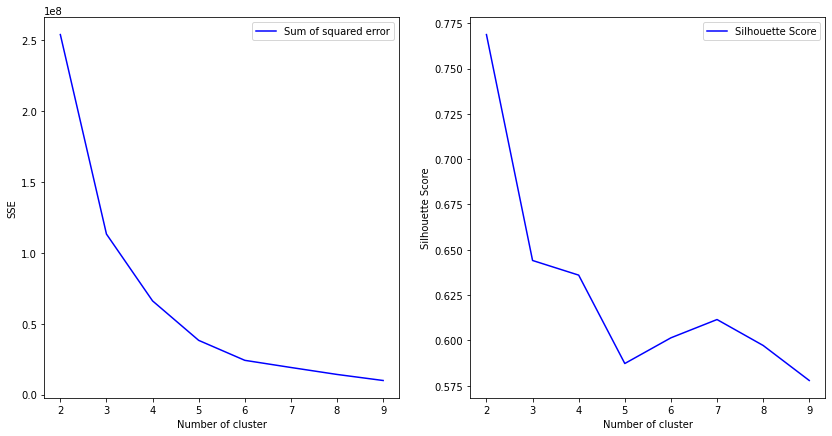

In [82]:
clusters= range(2,10)
elbow = []
ss=[]
for cluster in clusters:
    Kmeans1 = KMeans(n_clusters = cluster, random_state=0).fit(chennai_grpd_clustering)#KMeans Object
    Labels = Kmeans1.fit_predict(chennai_grpd_clustering) #Lables create
    silhouette_avg = silhouette_score(chennai_grpd_clustering, Labels, metric = 'euclidean')#silhoute score or sum of squared error
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, silhouette_avg))
    ss.append(silhouette_avg)
    elbow.append(Kmeans1.inertia_) # Inertia: Sum of distances of samples to their closest cluster center
    
fig = plt.figure(figsize=(14,7))
fig.add_subplot(121)
plt.plot(clusters, elbow,'b-',label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(clusters, ss,'b-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

#### As per this we chose cluster numbers to be **4**

In [83]:
#Number of cluster selected
Kclusters = 4
Kmeans = KMeans(n_clusters = Kclusters, random_state=0).fit(chennai_grpd_clustering)

#check cluster labels for rows in dataframe
Kmeans.labels_[0:10]

array([2, 1, 0, 0, 2, 2, 1, 0, 0, 0], dtype=int32)

##### Get clustering and top venues information in Chennai location dataframe

In [84]:
#insert column in dataframe for cluster labels
chennai_venues_sorted.insert(0,'Cluster label', Kmeans.labels_)

chennai_merged = chennai_neighbourhood_loc

#merge the two table and join on neighbourhood
chennai_merged = chennai_merged.join(chennai_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

chennai_merged.head()

,Neighbourhood,Number_of_societies,Mean_rate,Latitude,Longitude,Cluster label,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
0,Adambakkam,1,8606.0,12.982221,80.209121,2.0,IT Services,Pharmacy,Indian Restaurant,Dessert Shop,Food Service,Convenience Store,Cupcake Shop,Department Store,Electronics Store,Farmers Market
1,Adyar,1,13706.5,13.006450,80.257779,1.0,Indian Restaurant,Electronics Store,North Indian Restaurant,Ice Cream Shop,Rock Club,Grocery Store,Vegetarian / Vegan Restaurant,Italian Restaurant,Juice Bar,Lounge
2,Agraharam,1,4717.5,17.568600,82.850391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alandur,1,6672.0,13.002822,80.171919,0.0,Airport Service,Whisky Bar,Gastropub,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store,Farmers Market,Fast Food Restaurant
4,Ambattur,4,4675.0,13.112886,80.159862,0.0,Multiplex,Movie Theater,River,Whisky Bar,Coffee Shop,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store


In [85]:
chennai_merged.isnull().sum()

Neighbourhood              0
Number_of_societies        0
Mean_rate                  0
Latitude                   0
Longitude                  0
Cluster label             17
1st Most common venue     17
2nd Most common venue     17
3rd Most common venue     17
4th Most common venue     17
5th Most common venue     17
6th Most common venue     17
7th Most common venue     17
8th Most common venue     17
9th Most common venue     17
10th Most common venue    17
dtype: int64

There are few neighbourhoods for which there is no neighbourhood venues available in **Foursqaure.com**.\
We will drop those neighbourhoods from the dataframe.

In [86]:
chennai_merged1 = chennai_merged.dropna(subset=['Cluster label'],axis=0).reset_index(drop=True)
chennai_merged1.isnull().sum()

Neighbourhood             0
Number_of_societies       0
Mean_rate                 0
Latitude                  0
Longitude                 0
Cluster label             0
1st Most common venue     0
2nd Most common venue     0
3rd Most common venue     0
4th Most common venue     0
5th Most common venue     0
6th Most common venue     0
7th Most common venue     0
8th Most common venue     0
9th Most common venue     0
10th Most common venue    0
dtype: int64

In [87]:
print('NUmber of rows dropped due to unavailability of neighbourhood venues data is {}'.\
      format(chennai_merged.shape[0]-chennai_merged1.shape[0]))

NUmber of rows dropped due to unavailability of neighbourhood venues data is 17


##### The final data we have for Chennai neighbourhoods and their venues and respective cluster as below

In [88]:
chennai_merged1.head()

,Neighbourhood,Number_of_societies,Mean_rate,Latitude,Longitude,Cluster label,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
0,Adambakkam,1,8606.0,12.982221,80.209121,2.0,IT Services,Pharmacy,Indian Restaurant,Dessert Shop,Food Service,Convenience Store,Cupcake Shop,Department Store,Electronics Store,Farmers Market
1,Adyar,1,13706.5,13.006450,80.257779,1.0,Indian Restaurant,Electronics Store,North Indian Restaurant,Ice Cream Shop,Rock Club,Grocery Store,Vegetarian / Vegan Restaurant,Italian Restaurant,Juice Bar,Lounge
2,Alandur,1,6672.0,13.002822,80.171919,0.0,Airport Service,Whisky Bar,Gastropub,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store,Farmers Market,Fast Food Restaurant
3,Ambattur,4,4675.0,13.112886,80.159862,0.0,Multiplex,Movie Theater,River,Whisky Bar,Coffee Shop,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store
4,Anna Nagar,1,9010.0,13.087200,80.216442,2.0,Indian Restaurant,Fast Food Restaurant,Electronics Store,Chinese Restaurant,Café,Park,Bistro,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Department Store


#### 9. Visualise clusters on map

In [89]:
map_clusters = folium.Map(location=[chennai_lat,chennai_lon],zoom_start=10)

#set color scheme for clusters
x=np.arange(Kclusters)
ys = [i + x + (i*x)**2 for i in range(Kclusters)]
color_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in color_array]

#add markers
marker_colors = []

for lat,lon,Neighbourhood, cluster in zip(chennai_merged1['Latitude'],chennai_merged1['Longitude'],chennai_merged1['Neighbourhood'],\
                                          chennai_merged1['Cluster label']):
    label = '{},Cluster {}'.format(Neighbourhood,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lon], radius = 5, popup=label, color=rainbow[int(cluster)-1], fill=True, fill_color=rainbow[int(cluster)-1],\
                        fill_opacity=0.7,parse_html=False).add_to(map_clusters)
    
map_clusters

## F. Cluster Analysis
We will analyse each cluster and create a dataframe for each of the clusters

#### 1. Cluster Data

#### Cluster 1

In [90]:
Cluster1_data = chennai_merged1.loc[chennai_merged1['Cluster label']==0, chennai_merged1.columns[[0,1,2]+\
                                                                                                 list(range(5,chennai_merged1.shape[1]))]]
print('Number of Neighbourhoods in cluster1 is:', Cluster1_data.shape[0])
Cluster1_data

Number of Neighbourhoods in cluster1 is: 33


,Neighbourhood,Number_of_societies,Mean_rate,Cluster label,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
2,Alandur,1,6672.000000,0.0,Airport Service,Whisky Bar,Gastropub,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store,Farmers Market,Fast Food Restaurant
3,Ambattur,4,4675.000000,0.0,Multiplex,Movie Theater,River,Whisky Bar,Coffee Shop,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store
7,Avadi,2,3591.250000,0.0,IT Services,Art Gallery,Rental Service,Food Service,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store,Farmers Market
8,Ayanambakkam,1,5270.000000,0.0,Pharmacy,Electronics Store,Lake,Food Service,Concert Hall,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Farmers Market
9,Chitlapakkam,1,3315.000000,0.0,Lake,Food & Drink Shop,Whisky Bar,Gastropub,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store,Farmers Market
10,Chromepet,3,4611.333333,0.0,Indian Restaurant,Ice Cream Shop,Bakery,Clothing Store,Department Store,Movie Theater,Bus Station,Road,Light Rail Station,Shopping Mall
12,Guduvancheri,3,3548.833333,0.0,North Indian Restaurant,Train Station,Indian Restaurant,Bus Station,Whisky Bar,Food Service,Cupcake Shop,Department Store,Dessert Shop,Electronics Store
14,Karapakkam,2,5833.000000,0.0,Indian Restaurant,Multicuisine Indian Restaurant,Bakery,Whisky Bar,Food Service,Cupcake Shop,Department Store,Dessert Shop,Electronics Store,Farmers Market
15,Kelambakkam,2,3612.500000,0.0,Coffee Shop,Indian Restaurant,Indian Sweet Shop,Café,Bar,Bus Station,Mobile Phone Shop,Food Service,Department Store,Dessert Shop
16,Korattur,1,6056.000000,0.0,Convenience Store,Cupcake Shop,Campground,Dessert Shop,Spa,Fast Food Restaurant,Whisky Bar,Food Service,Department Store,Electronics Store


#### Cluster 2

In [91]:
Cluster2_data = chennai_merged1.loc[chennai_merged1['Cluster label']==1, chennai_merged1.columns[[0,1,2]+\
                                                                                                 list(range(5,chennai_merged1.shape[1]))]]
print('Number of Neighbourhoods in cluster 2 is:', Cluster2_data.shape[0])
Cluster2_data

Number of Neighbourhoods in cluster 2 is: 4


,Neighbourhood,Number_of_societies,Mean_rate,Cluster label,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
1,Adyar,1,13706.500000,1.0,Indian Restaurant,Electronics Store,North Indian Restaurant,Ice Cream Shop,Rock Club,Grocery Store,Vegetarian / Vegan Restaurant,Italian Restaurant,Juice Bar,Lounge
6,Anna Salai,1,17021.000000,1.0,Hotel,Afghan Restaurant,Indian Restaurant,BBQ Joint,Fast Food Restaurant,Restaurant,Whisky Bar,Food Service,Cupcake Shop,Department Store
11,Egmore,3,15200.833333,1.0,Shopping Mall,Indian Restaurant,Sandwich Place,Café,Motel,Farmers Market,Coffee Shop,Seafood Restaurant,Museum,Theater
46,Teynampet,1,17085.000000,1.0,Lounge,Hotel,Bowling Alley,Indian Restaurant,Italian Restaurant,Nightclub,Chinese Restaurant,Café,Coffee Shop,BBQ Joint


#### Cluster 3

In [92]:
Cluster3_data = chennai_merged1.loc[chennai_merged1['Cluster label']==2, chennai_merged1.columns[[0,1,2]+\
                                                                                                 list(range(5,chennai_merged1.shape[1]))]]
print('Number of Neighbourhoods in cluster 3 is:', Cluster3_data.shape[0])
Cluster3_data

Number of Neighbourhoods in cluster 3 is: 12


,Neighbourhood,Number_of_societies,Mean_rate,Cluster label,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
0,Adambakkam,1,8606.000,2.0,IT Services,Pharmacy,Indian Restaurant,Dessert Shop,Food Service,Convenience Store,Cupcake Shop,Department Store,Electronics Store,Farmers Market
4,Anna Nagar,1,9010.000,2.0,Indian Restaurant,Fast Food Restaurant,Electronics Store,Chinese Restaurant,Café,Park,Bistro,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Department Store
5,Anna Nagar West,1,7905.000,2.0,Café,Ice Cream Shop,Department Store,Juice Bar,Kerala Restaurant,Park,Food Court,Convenience Store,Cupcake Shop,Dessert Shop
13,Guindy,1,11241.000,2.0,Hotel,Restaurant,Indian Restaurant,Spa,Whisky Bar,Italian Restaurant,Molecular Gastronomy Restaurant,Bus Station,Lounge,Dessert Shop
17,Kovilambakkam,1,7034.000,2.0,Indian Restaurant,Whisky Bar,Gastropub,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store,Farmers Market,Fast Food Restaurant
19,Koyambedu,1,8883.000,2.0,Bus Station,Metro Station,Multiplex,Antique Shop,Movie Theater,South Indian Restaurant,Bakery,Flower Shop,Whisky Bar,Department Store
28,Mogappair East,1,8330.000,2.0,Sandwich Place,Indian Restaurant,Health Food Store,Department Store,Whisky Bar,Convenience Store,Cupcake Shop,Dessert Shop,Electronics Store,Farmers Market
38,Perungudi,4,8069.625,2.0,Indian Restaurant,Food Service,Sandwich Place,Pizza Place,Café,Cafeteria,Fast Food Restaurant,Food Court,Cupcake Shop,Department Store
41,Saidapet,1,11347.500,2.0,Hotel Bar,Train Station,BBQ Joint,Motel,Food Service,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store
42,Saligramam,1,8458.000,2.0,Department Store,Pet Store,Pool Hall,Coffee Shop,Indian Restaurant,Health Food Store,Halal Restaurant,Concert Hall,Convenience Store,Cupcake Shop


#### Cluster 4

In [93]:
Cluster4_data = chennai_merged1.loc[chennai_merged1['Cluster label']==3, chennai_merged1.columns[[0,1,2]+\
                                                                                                 list(range(5,chennai_merged1.shape[1]))]]
print('Number of Neighbourhoods in cluster 4 is:', Cluster4_data.shape[0])
Cluster4_data

Number of Neighbourhoods in cluster 4 is: 3


,Neighbourhood,Number_of_societies,Mean_rate,Cluster label,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
21,MRC Nagar,1,20761.5,3.0,Hotel,Indian Restaurant,Hotel Bar,Gastropub,Chinese Restaurant,Gym / Fitness Center,Nightclub,Sandwich Place,Restaurant,Bakery
30,Mount Road,1,19550.0,3.0,Bed & Breakfast,Whisky Bar,Gastropub,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store,Farmers Market,Fast Food Restaurant
33,Nungambakkam,2,22727.0,3.0,Indian Restaurant,Gourmet Shop,Fast Food Restaurant,Halal Restaurant,Chinese Restaurant,Asian Restaurant,Juice Bar,Café,South Indian Restaurant,Bakery


#### Cluster 5

In [94]:
Cluster5_data = chennai_merged1.loc[chennai_merged1['Cluster label']==4, chennai_merged1.columns[[0,1,2]+\
                                                                                                 list(range(5,chennai_merged1.shape[1]))]]
print('Number of Neighbourhoods in cluster 5 is:', Cluster5_data.shape[0])
Cluster5_data

Number of Neighbourhoods in cluster 5 is: 0


,Neighbourhood,Number_of_societies,Mean_rate,Cluster label,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue


#### 2. Cluster detail
Here we will plot clusters on various plots to see the difference and define each cluster

In [95]:
#Lets get the clusters data
chennai_merged1.head()

,Neighbourhood,Number_of_societies,Mean_rate,Latitude,Longitude,Cluster label,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
0,Adambakkam,1,8606.0,12.982221,80.209121,2.0,IT Services,Pharmacy,Indian Restaurant,Dessert Shop,Food Service,Convenience Store,Cupcake Shop,Department Store,Electronics Store,Farmers Market
1,Adyar,1,13706.5,13.006450,80.257779,1.0,Indian Restaurant,Electronics Store,North Indian Restaurant,Ice Cream Shop,Rock Club,Grocery Store,Vegetarian / Vegan Restaurant,Italian Restaurant,Juice Bar,Lounge
2,Alandur,1,6672.0,13.002822,80.171919,0.0,Airport Service,Whisky Bar,Gastropub,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store,Farmers Market,Fast Food Restaurant
3,Ambattur,4,4675.0,13.112886,80.159862,0.0,Multiplex,Movie Theater,River,Whisky Bar,Coffee Shop,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Electronics Store
4,Anna Nagar,1,9010.0,13.087200,80.216442,2.0,Indian Restaurant,Fast Food Restaurant,Electronics Store,Chinese Restaurant,Café,Park,Bistro,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Department Store


#### 3. Cluster Mean_rate range

In [96]:
# Import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
print('Imported')

Imported


<AxesSubplot:xlabel='Cluster label', ylabel='Mean_rate'>

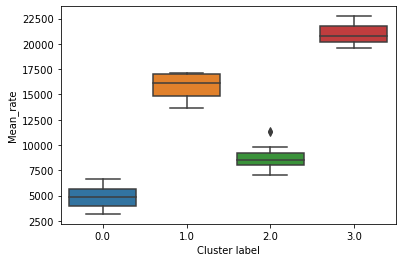

In [97]:
boxplot = sns.boxplot(x='Cluster label', y='Mean_rate', data=chennai_merged1)
boxplot

##### As we can see from above we box plot we can say arrange the cluster in descending order of costs as\
Cluster 4 - Highest mean rates\
Cluster 2\
Cluster 3\
Cluster 1 - Lowest mean rates

#### 4. Cluster Mean_Rates vs Distance_from Center

Let us review whether the mean rates of these clusters are dependent on the distance of city center or not

In [98]:
# Get the relevant columns from the dataframe
columns = chennai_merged1.columns[0:6]
chennai_center = chennai_merged1[columns]
chennai_center.head()

,Neighbourhood,Number_of_societies,Mean_rate,Latitude,Longitude,Cluster label
0,Adambakkam,1,8606.0,12.982221,80.209121,2.0
1,Adyar,1,13706.5,13.006450,80.257779,1.0
2,Alandur,1,6672.0,13.002822,80.171919,0.0
3,Ambattur,4,4675.0,13.112886,80.159862,0.0
4,Anna Nagar,1,9010.0,13.087200,80.216442,2.0


In [99]:
# Lets recall the Chennai geo cords from earlier codes
print(chennai_lat, chennai_lon)

13.0836939 80.270186


In [100]:
from geopy.distance import geodesic

In [101]:
# Try to calculate distance between 1st row and Chennai center
distance = geodesic((chennai_center.loc[0,'Latitude'],chennai_center.loc[0,'Longitude']),(chennai_lat,chennai_lon)).km
distance

13.034431028969973

In [102]:
# now create a loop to get distance from center for each row
distance_center=[]
for lat,lon in zip(chennai_center['Latitude'],chennai_center['Longitude']):
    distance_center.append(geodesic((lat,lon),(chennai_lat,chennai_lon)))

chennai_center['Distance_from_center'] = distance_center
chennai_center.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Neighbourhood,Number_of_societies,Mean_rate,Latitude,Longitude,Cluster label,Distance_from_center
0,Adambakkam,1,8606.0,12.982221,80.209121,2.0,13.034431028969973 km
1,Adyar,1,13706.5,13.006450,80.257779,1.0,8.650869623130786 km
2,Alandur,1,6672.0,13.002822,80.171919,0.0,13.916016799598301 km
3,Ambattur,4,4675.0,13.112886,80.159862,0.0,12.391948683968447 km
4,Anna Nagar,1,9010.0,13.087200,80.216442,2.0,5.841288436458663 km


In [103]:
chennai_center['Distance_from_center'] = chennai_center['Distance_from_center'].astype('string')
chennai_center.dtypes

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Neighbourhood            object
Number_of_societies       int64
Mean_rate               float64
Latitude                float64
Longitude               float64
Cluster label           float64
Distance_from_center     string
dtype: object

In [104]:
chennai_center['Distance_from_center'] = chennai_center.Distance_from_center.str.split(" ",expand=False)
chennai_center.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighbourhood,Number_of_societies,Mean_rate,Latitude,Longitude,Cluster label,Distance_from_center
0,Adambakkam,1,8606.0,12.982221,80.209121,2.0,"[13.034431028969973, km]"
1,Adyar,1,13706.5,13.006450,80.257779,1.0,"[8.650869623130786, km]"
2,Alandur,1,6672.0,13.002822,80.171919,0.0,"[13.916016799598301, km]"
3,Ambattur,4,4675.0,13.112886,80.159862,0.0,"[12.391948683968447, km]"
4,Anna Nagar,1,9010.0,13.087200,80.216442,2.0,"[5.841288436458663, km]"


In [105]:
type(float(chennai_center.loc[0,'Distance_from_center'][0]))

float

In [106]:
chennai_center['Distance_from_center'] = chennai_center['Distance_from_center'].apply(lambda x : float(x[0]))
chennai_center.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighbourhood,Number_of_societies,Mean_rate,Latitude,Longitude,Cluster label,Distance_from_center
0,Adambakkam,1,8606.0,12.982221,80.209121,2.0,13.034431
1,Adyar,1,13706.5,13.006450,80.257779,1.0,8.650870
2,Alandur,1,6672.0,13.002822,80.171919,0.0,13.916017
3,Ambattur,4,4675.0,13.112886,80.159862,0.0,12.391949
4,Anna Nagar,1,9010.0,13.087200,80.216442,2.0,5.841288


<AxesSubplot:title={'center':'Mean rate vs Distance from Center'}, xlabel='Distance from center in KM', ylabel='Mean rates'>

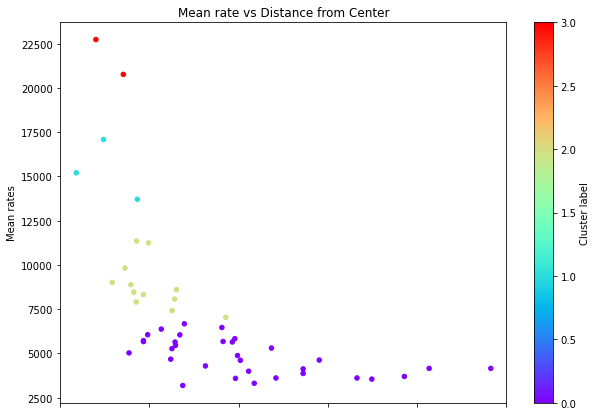

In [107]:
#lets make a scatter plot
ax = chennai_center.plot(kind='scatter', x='Distance_from_center', y='Mean_rate',xlim=(0,50),figsize=(10,7), \
                         c='Cluster label',cmap='rainbow')
ax.set_title('Mean rate vs Distance from Center')
ax.set_xlabel('Distance from center in KM')
ax.set_ylabel('Mean rates')


ax

The results as we can see from the scatter plot is that as the distance increases from city center the mean rates drop.\
and the clusters can be arranges as per descending mean rates is as \
Cluster 4 - Highest mean rate & close to center\
Cluster 2 \
Cluster 3\
Cluster 1 - Lowest mean rate & farthest from center\


In [108]:
## Is there a correlation between distance and price
chennai_center[['Distance_from_center','Mean_rate']].corr()

,Distance_from_center,Mean_rate
Distance_from_center,1.000000,0.357453
Mean_rate,0.357453,1.000000


Hence we see that there is no correlation between Mean_rate in a neighbourhood and Distance from center.\
There might be few other variables that can be utilised to project the mean rate of any upcoming project in a particular neighbourhood.


**Now lets plot the box plot and scatter plot side by side and compare.**

Text(0, 0.5, 'Mean rates')

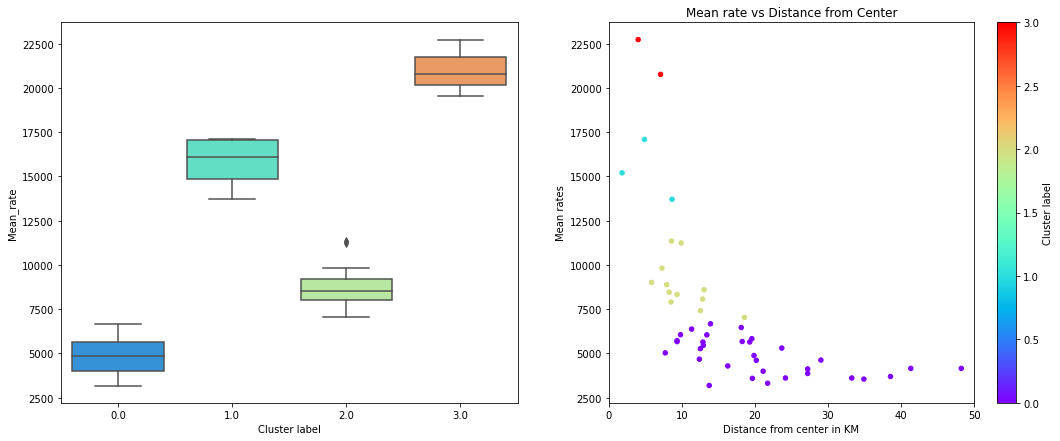

In [110]:
fig=plt.figure(figsize=(18,7))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
sns.boxplot(x='Cluster label', y='Mean_rate', data=chennai_merged1,ax=ax0,palette='rainbow')

chennai_center.plot(kind='scatter', x='Distance_from_center', y='Mean_rate',xlim=(0,50),c='Cluster label',cmap='rainbow',ax=ax1)
plt.title('Mean rate vs Distance from Center')
plt.xlabel('Distance from center in KM')
plt.ylabel('Mean rates')

## G. Discussion

I began this project with intetion to help **buyers and investors** to identify the neighbourhood they can invest in.\
I used the input data of various housing societies and their respective cost range from [99acres.com][1]. This data from website was scraped using **BeautifulSoup** and the dataframe was cleaned to have the relevant information of **Society name, Neighbourhood, Minimum rate and Maximum rate**.\
The data was further aggregated to get the average housing rates and number of housing societies in each neighbourhood.\
**Nominatim** library was utilised to get the geo-coordinates for these Neighbouhoods. By utilising **Foursquare API** the nearby venues data was extracted. It was observed that for several neighbourhoods data for nearby venues was not available. Those neighbourhoods had to be dropped from the data. **Top ten venues** were extracted for each neighbourhood.

**Elbow method** was used to determine the optimum K value for the **KMeans** clustering. The data was then clustered using **k=4**. 
These clusters were listed and later analysed by using **Box plot** for the Mean_rate for each cluster.

I tried to see whether the rates of these neighbourhood have any relation to the Chennai center. So, I used the **geodesic** library to get the distance between these neighbourhoods and the Chennai center. The data was plotted on the **Scatter plot**.

The outcome of **Box plot** and **Scatter plot** were used to define the clusters.\
Below table shows the ranking of the cluster on parameters of mean rate and distance from center.\
_Rank 1 is highest and 4 is lowest_.

Cluster Label | Mean_Rate Rank | Distance_from_Center rank | No. of Neighbourhoods
--- | --- | --- | ---
Cluster 4 |  1 | 4 | 3
Cluster 2 |  2 | 3 | 4 
Cluster 3 | 3  | 2 | 12
Cluster 1 | 4 | 1 | 33 

Hence we can define clusters as
1. Cluster 4 - Highest mean rates, closest to center with least neighbourhoods
2. Cluster 2 - High mean rates, closer to center with low neighbourhoods
3. Cluster 3 - Low mean rates, far from center with higher neighbourhoods
4. Cluster 1 - Lowest mean rate, farthest from center with highest neighbourhoods

I saw that as we go far from center the number of neighbourhoods increased and the mean_rate decreased.\
The lower mean_rates of the neighbourhoods farther from the center could be a reason for high number of neighbourhoods in those area.

I tried to find a correlation between distance from center and the mean_rates.\
As a result I found that there is a minor negative correlation between the mean-rates and the distance from center.\
However the correlation was **0.35** so we can say there might be other variables that we need in data to project the rate of housing in a neighbourhood and simply using distance from center will not give a reliable projection.



[1]:https://www.99acres.com/property-rates-and-price-trends-in-chennai

## H. Conclusion

There are several insights that we have from this model.
1. An investor would have more options to invest far from center at lower rates.
2. As he comes closer to Chennai center, options narow down and mean rate increases.
3. With improved data quality, Foursquare results the clustering can be further improved.
4. Availability of additional data about housing can be utilised to estimate the housing rates. This can further enable the investor to buy at optimum rates.